In [1]:
import sys
sys.path.append("../")

import os
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage
from typing_extensions import Annotated, TypedDict
from utils.model_loader import ModelLoader
from agent_tools.tools import retriever_tool, financials_tool, tavilytool
from typing import Any, Dict, Optional
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_openai import AzureOpenAIEmbeddings

c:\Users\mksgh\OneDrive - Vestas Wind Systems A S\Documents\Github\TradingBot-agentic-langchain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")  # type: ignore
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT") # type: ignore
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME") # type: ignore
os.environ["OPENAI_API_VERSION"] = os.getenv("AZURE_OPENAI_API_VERSION") # type: ignore

llm = init_chat_model(
    "azure_openai:gpt-4.1",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
)

# Initialize the Polygon API wrapper
polygon_api_wrapper = PolygonAPIWrapper()
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon_api_wrapper)


In [ ]:
# testing embedding

from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small"
    # dimensions: Optional[int] = None, # Can specify dimensions with new text-embedding-3 models
    # azure_endpoint="https://<your-endpoint>.openai.azure.com/", If not provided, will read env variable AZURE_OPENAI_ENDPOINT
    # api_key=... # Can provide an API key directly. If missing read env variable AZURE_OPENAI_API_KEY
    # openai_api_version=..., # If not provided, will read env variable AZURE_OPENAI_API_VERSION
)

input_text = "The meaning of life is 42"
vector = embeddings.embed_query(input_text)
print(vector[:3])

In [35]:
class State(TypedDict):
    """
    Represents the state for the workflow graph.
    """
    messages: Annotated[list, add_messages]

In [40]:
class GraphBuilder:
    """
    Builds and manages a conversational workflow graph with LLM and tools integration.
    """

    def __init__(self) -> None:
        """
        Initializes the GraphBuilder with LLM, tools, and prepares for graph construction.
        """
        self.model_loader: ModelLoader = ModelLoader()
        self.llm: Any = llm
        self.tools: list = [retriever_tool, tavilytool] + toolkit.get_tools()
        self.llm_with_tools: Any = self.llm.bind_tools(tools=self.tools)
        self.graph: Optional[Any] = None

    def _chatbot_node(self, state: State) -> Dict[str, list]:
        """
        Node function for chatbot: invokes the LLM with tools on the current state messages.

        Parameters
        ----------
        state : State
            The current state containing the conversation messages.

        Returns
        -------
        dict
            A dictionary with updated messages after LLM invocation.
        """
        return {"messages": [self.llm_with_tools.invoke(state["messages"])]}

    def build(self) -> None:
        """
        Builds and compiles the workflow graph with chatbot and tool nodes.
        """
        graph_builder: StateGraph = StateGraph(State)
        graph_builder.add_node("chatbot", self._chatbot_node)
        tool_node: ToolNode = ToolNode(tools=self.tools)
        
        graph_builder.add_node("tools", tool_node)
        graph_builder.add_conditional_edges("chatbot", tools_condition)
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_edge(START, "chatbot")

        self.graph = graph_builder.compile()

    def get_graph(self) -> Any:
        """
        Returns the compiled workflow graph.

        Returns
        -------
        Any
            The compiled workflow graph.

        Raises
        ------
        ValueError
            If the graph has not been built yet.
        """
        if self.graph is None:
            raise ValueError("Graph not built. Call build() first.")
        return self.graph

In [41]:
g = GraphBuilder()
g.build()

graph = g.get_graph()

try:
    display(Image(g.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

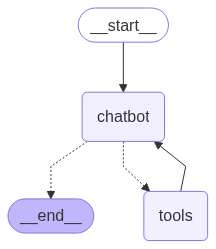

In [42]:
g.get_graph()

In [47]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "4"}},
    stream_mode="values"):
         event["messages"][-1].pretty_print()

while True:
    # try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

================================ Human Message =================================

you are financial expert and you answer ll the queries in most precise manner. Also you always look for the ticker for a asked company then do the asked job with the right ticker.
================================== Ai Message ==================================

Great! Please provide me with the company or ticker for which you need financial information, stock price, news, or any other details. I'll ensure I use the correct ticker and provide precise information.
================================ Human Message =================================

reliance last quater balance sheet.
================================== Ai Message ==================================
Tool Calls:
  polygon_financials (call_lo8P7nPoMgmS3dmgzLqwTAm3)
 Call ID: call_lo8P7nPoMgmS3dmgzLqwTAm3
  Args:
    query: reliance
================================= Tool Message =================================
Name: polygon_financials

[]
=========